In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../SyMBac/')
sys.path.insert(1, '../../single_cell_projection_diffraction/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale

plt.style.use(["science", 'nature'])

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6



In [3]:
resize_amount = 1
pix_mic_conv = 0.065 / 17

all_data = pd.read_pickle("../../single_cell_projection_diffraction/all_data.pickle")

wavelength_colours = ["k", "b", "g", "orange", "r"] 

standard_cell = all_data.query("`True Width` == 1.04")


max_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].max()
min_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].min()
high_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @min_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()

max_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].max()
min_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].min()
high_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @min_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
high_low_dof = pd.concat([high_dof_wavelength_FL, low_dof_wavelength_FL, high_dof_wavelength_membrane, low_dof_wavelength_membrane])
high_low_dof = pd.concat([high_dof_wavelength_FL, low_dof_wavelength_FL, high_dof_wavelength_membrane, low_dof_wavelength_membrane])
imshow_data = all_data.loc[high_low_dof.index]

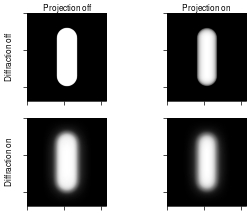

In [4]:
##00 = proj, diff
def FL_imshow(into_subplot = False, axs = None):
    if not into_subplot:
        fig, axs = plt.subplots(2,2)
        FL_00, FL_10, FL_01, FL_11 = axs.flatten()
    else:
        FL_00, FL_10, FL_01, FL_11 = axs
    

    FL_00.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    FL_10.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    FL_01.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    FL_11.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    for ax in [FL_00, FL_10, FL_01, FL_11]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    FL_00.set_xlabel('Projection off',labelpad=2)
    FL_00.xaxis.set_label_position('top') 
    FL_00.set_ylabel("Diffraction off")
    
    FL_10.set_xlabel("Projection on",labelpad=2)
    FL_10.xaxis.set_label_position('top') 
    
    FL_01.set_ylabel("Diffraction on")
    

    
    #plt.tight_layout()
    if not into_subplot:
        plt.show()

FL_imshow()


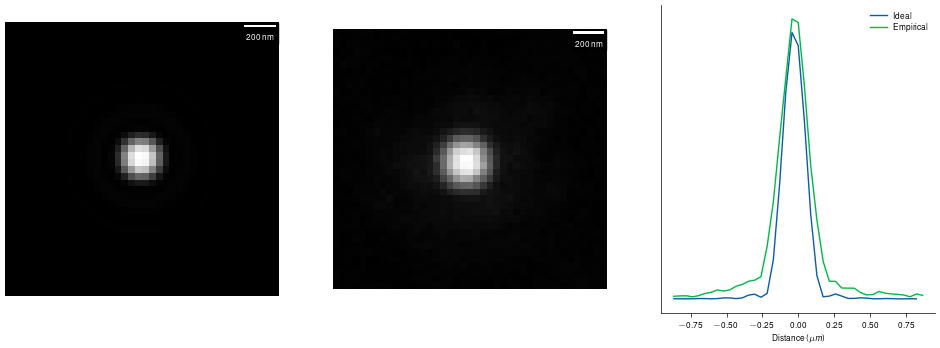

In [5]:
pix_mic_conv_PSF = 0.0433333766667

synth_PSF = tifffile.imread("../../PSF_comparison/synth_PSF.tif")
real_PSF = tifffile.imread("../../PSF_comparison/real_PSF.tif")


fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(synth_PSF, cmap="Greys_r")
axs[1].imshow(real_PSF, cmap="Greys_r")


scalebar = ScaleBar(pix_mic_conv_PSF, "um", length_fraction=0.25, color="white", box_color="k")
axs[0].add_artist(scalebar)
scalebar = ScaleBar(pix_mic_conv_PSF, "um", length_fraction=0.25, color="white", box_color="k")
axs[1].add_artist(scalebar)

for ax in axs.flatten()[:2]:
    ax.axis("off")

real_x_axis = np.arange(real_PSF.shape[1]) - real_PSF.shape[0]//2-1
real_x_axis = real_x_axis.astype(float) * pix_mic_conv_PSF
kernel_x_axis = np.arange(synth_PSF.shape[0]) -synth_PSF.shape[0]//2
kernel_x_axis = kernel_x_axis.astype(float) * pix_mic_conv_PSF

axs[2].plot(kernel_x_axis, synth_PSF[synth_PSF.shape[0]//2]/synth_PSF.max())
axs[2].plot(real_x_axis, real_PSF[real_PSF.shape[0]//2]/real_PSF.max())
axs[2].legend(["Ideal", "Empirical"])
axs[2].set_xlabel("Distance ($\mu m$)")
axs[2].set_yticks([])
plt.show()

In [6]:
real_cell = tifffile.imread("real_cell_YFP.tif").astype(np.float64)
real_cell -= np.sort(real_cell.flatten())[:int(len(real_cell.flatten())*0.05)].mean()
real_cell = rotate(real_cell, 19.5+90, preserve_range=True, clip=True)
real_cell /= real_cell.max()
real_cell = real_cell[40:-45,50:-50]

In [7]:
0.065/17 * 270

1.0323529411764707

Text(0.5, 1.0, 'Synth cell')

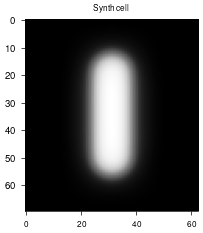

In [8]:
synth_single_cell = np.load("57_FL_784_272_270_0.0_0.6.npy")[200:-200,:]
synth_single_cell = rescale(synth_single_cell,1/17)
synth_single_cell /= synth_single_cell.max()
plt.imshow(synth_single_cell, cmap="Greys_r")
plt.title("Synth cell")

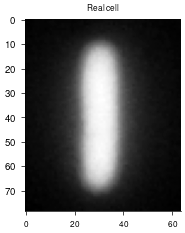

In [9]:
plt.imshow(real_cell, cmap="Greys_r")
plt.title("Real cell")
plt.show()

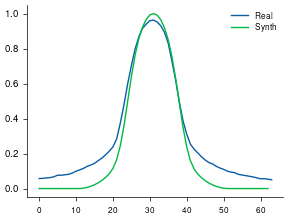

In [10]:
plt.plot(real_cell[int(real_cell.shape[0]//2)-5:int(real_cell.shape[0]//2)+5,:].mean(axis=0))
plt.plot(synth_single_cell[int(synth_single_cell.shape[0]//2)-5:int(synth_single_cell.shape[0]//2)+5,:].mean(axis=0))
plt.legend(["Real", "Synth"])

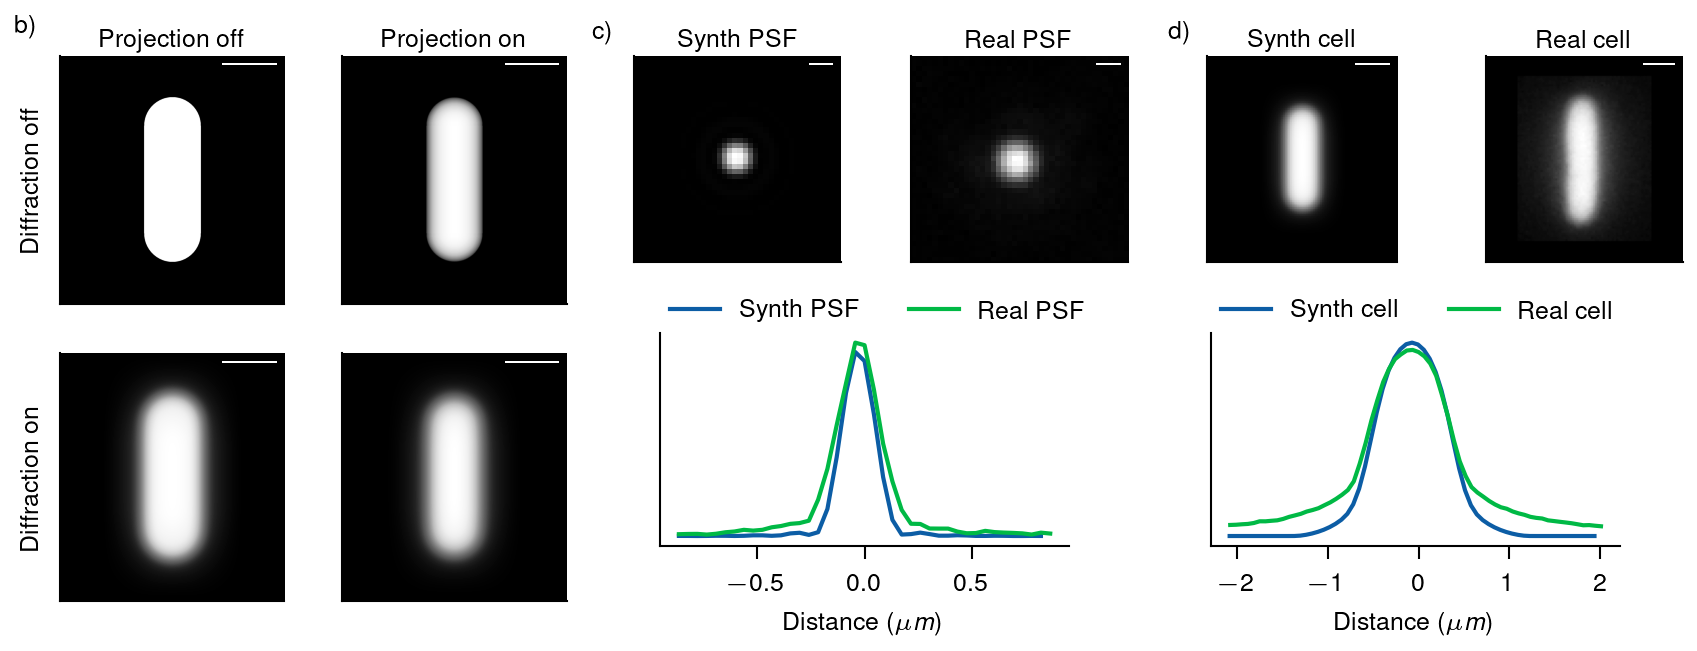

In [25]:
######### Main figure #############
cm = 1/2.54
fig = plt.subplots(figsize = (18*cm,6*cm), dpi = 300)
a = matplotlib.cm.get_cmap('Set2')
######### Projection diffraction grid #############

FL_00 = plt.subplot2grid((2, 6), (0, 0), colspan=1)
FL_10 = plt.subplot2grid((2, 6), (0, 1), colspan=1)
FL_01 = plt.subplot2grid((2, 6), (1, 0), colspan=1)
FL_11 = plt.subplot2grid((2, 6), (1, 1), colspan=1)
plt.text(-.2, 1.165, 'b)', ha='left', va='top', transform=FL_00.transAxes)
for ax in [FL_00, FL_10, FL_01, FL_11]:
    ax.set_xticks([])
    ax.set_yticks([])
    scalebar = ScaleBar(pix_mic_conv, "um", length_fraction=0.25, scale_loc="none", box_alpha=0, color="white", box_color="k") # 1 micon
    ax.add_artist(scalebar)
    
FL_00.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )
FL_10.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )
FL_01.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )
FL_11.imshow(  np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )
FL_00.set_xlabel('Projection off',labelpad=2)
FL_00.xaxis.set_label_position('top') 
FL_00.set_ylabel("Diffraction off")
FL_10.set_xlabel("Projection on",labelpad=2)
FL_10.xaxis.set_label_position('top') 
FL_01.set_ylabel("Diffraction on")



######### PSF comparison #############

SYNTH_PSF = plt.subplot2grid((5, 6), (0, 2), colspan=1, rowspan=2)
plt.text(-.2, 1.165, 'c)', ha='left', va='top', transform=SYNTH_PSF.transAxes)
REAL_PSF = plt.subplot2grid((5, 6), (0, 3), colspan=1, rowspan=2)
for ax in [SYNTH_PSF, REAL_PSF]:
    ax.set_xticks([])
    ax.set_yticks([])
    scalebar = ScaleBar(pix_mic_conv_PSF, "um", length_fraction=0.25, color="white", box_color="k",  scale_loc="none", box_alpha=0) # 0.2 micron 
    ax.add_artist(scalebar)
    
SYNTH_PSF.imshow(synth_PSF, cmap="Greys_r")
SYNTH_PSF.set_xlabel('Synth PSF',labelpad=2)
SYNTH_PSF.xaxis.set_label_position('top') 

REAL_PSF.imshow(real_PSF, cmap="Greys_r")
REAL_PSF.set_xlabel('Real PSF',labelpad=2)
REAL_PSF.xaxis.set_label_position('top') 

from seaborn import move_legend
PSF_COMPARISON = plt.subplot2grid((10, 60), (5, 22), colspan=15, rowspan=4)
PSF_COMPARISON.plot(kernel_x_axis, synth_PSF[synth_PSF.shape[0]//2]/synth_PSF.max(), label = "Synth PSF")
PSF_COMPARISON.plot(real_x_axis, real_PSF[real_PSF.shape[0]//2]/real_PSF.max(), label = "Real PSF")
PSF_COMPARISON.legend()
PSF_COMPARISON.set_xlabel("Distance ($\mu m$)")
PSF_COMPARISON.set_yticks([])
move_legend(PSF_COMPARISON, (0,1), ncol=2)

######### Real cell comparison #############
SYNTH_CELL = plt.subplot2grid((5, 6), (0, 4), colspan=1, rowspan=2)
SYNTH_CELL.xaxis.set_label_position('top') 
SYNTH_CELL.set_xlabel("Synth cell",labelpad=2)
plt.text(-.2, 1.165, 'd)', ha='left', va='top', transform=SYNTH_CELL.transAxes)

REAL_CELL = plt.subplot2grid((5, 6), (0, 5), colspan=1, rowspan=2)
REAL_CELL.xaxis.set_label_position('top') 
REAL_CELL.set_xlabel("Real cell",labelpad=2)
for ax in [SYNTH_CELL, REAL_CELL]:
    ax.set_xticks([])
    ax.set_yticks([])
    scalebar = ScaleBar(pix_mic_conv*17, "um", length_fraction=0.25, color="white", scale_loc="none", box_alpha=0, box_color="k") # 1 micron
    ax.add_artist(scalebar)


synth_single_cell_imshow =  np.pad(synth_single_cell, ((10,10),(10,10)))
#synth_single_cell_imshow = synth_single_cell[5:-5,:]
SYNTH_CELL.imshow(synth_single_cell_imshow, cmap="Greys_r")

real_cell_imshow = np.pad(real_cell, ((10,10),(15,15)))
REAL_CELL.imshow(real_cell_imshow, cmap="Greys_r")


CELL_COMPARISON = plt.subplot2grid((10, 60), (5, 42), colspan=15, rowspan=4)
CELL_COMPARISON.set_xlabel("Distance ($\mu m$)")
CELL_COMPARISON.set_yticks([])
y1 = synth_single_cell[int(synth_single_cell.shape[0]//2)-5:int(synth_single_cell.shape[0]//2)+5,:].mean(axis=0)
x1 = np.arange(0,len(y1)).astype(float)
x1 -= len(x1)/2+0.6
x1 *= 0.065

y2 = real_cell[int(real_cell.shape[0]//2)-5:int(real_cell.shape[0]//2)+5,:].mean(axis=0)
x2 = np.arange(0,len(y2)).astype(float)
x2 -= len(x2)/2
x2 *= 0.065

plt.plot(x1, y1, label="Synth cell")
plt.plot(x2, y2, label="Real cell")
plt.legend()
move_legend(CELL_COMPARISON, (0,1), ncol=2)


plt.savefig("figure_1.svg")
